In [63]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

In [64]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col = 0)

In [65]:
checkpoint = torch.load("../test/Brian/nov22_test01/final/checkpoint_final.tar")
demo_df = pd.read_csv("../split_datasets/live_demo.csv")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")
demo_df = demo_df.drop(columns="amenities")

In [66]:
demo_df

,host_is_superhost,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,amenities_count,facilities_Free parking on premises,facilities_Gym,facilities_Hot tub,facilities_Pool,facilities_count,house_rules_Suitable for events,house_rules_Pets allowed,house_rules_Smoking allowed,house_rules_count
0,0,-0.881203,-0.896103,-0.061014,1.182045,1.329375,-1.165452,0.652325,-0.353343,-0.650700,...,0.293298,0,0,0,0,-0.901841,0,0,0,-0.410572
1,0,0.145206,-0.333142,0.222818,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,-0.427262,0,0,0,0,-0.901841,0,0,0,-0.410572
2,0,-1.042496,1.851645,1.795044,-0.986725,1.329375,-0.597957,-0.436242,-0.353343,-0.650700,...,-0.427262,0,0,0,0,-0.901841,0,0,0,-0.410572
3,1,-0.617269,2.360930,0.983627,-0.444532,-0.686927,1.104526,0.652325,0.953672,0.389812,...,0.293298,0,0,0,0,-0.901841,0,0,0,-0.410572
4,1,0.541107,-0.491634,-1.055418,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,0.293298,0,0,0,0,-0.901841,0,0,0,-0.410572
5,0,-0.455976,-0.276603,-2.584298,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,0.653578,0,0,0,0,-0.901841,0,0,0,-0.410572
6,1,-0.807888,-0.351967,-0.797598,2.266429,-0.686927,-0.597957,-0.436242,-1.660357,-0.650700,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
7,0,-0.734573,0.303578,-1.091032,-1.528917,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,...,0.653578,0,0,0,0,-0.901841,0,0,0,-0.410572
8,0,3.371063,0.751704,0.044698,0.097660,-0.686927,1.672021,5.006591,2.260687,1.430323,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
9,1,-0.236032,-0.684738,0.100713,1.182045,3.345677,-0.597957,-0.436242,-0.353343,-0.650700,...,0.653578,0,0,0,0,-0.901841,0,0,0,-0.410572


In [67]:
test_df

,host_is_superhost,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,...,amenities_count,facilities_Free parking on premises,facilities_Gym,facilities_Hot tub,facilities_Pool,facilities_count,house_rules_Suitable for events,house_rules_Pets allowed,house_rules_Smoking allowed,house_rules_count
0,0,-0.790334,0.371405,-0.444532,1.329375,-0.597957,0.652325,-0.353343,-0.650700,-0.294683,...,-2.228663,1,1,0,1,1.638226,0,0,0,-0.410572
1,0,-0.122362,0.210520,-0.444532,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,0.306499,...,1.013858,0,0,0,0,-0.901841,0,0,0,-0.410572
2,0,-0.139712,0.227703,-0.444532,1.329375,-0.597957,-0.436242,-0.353343,-0.650700,-0.221369,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
3,0,-0.713994,-0.104175,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,0.365151,...,0.293298,0,1,1,1,1.638226,0,0,0,-0.410572
4,0,-0.972291,0.710358,-0.986725,-0.686927,1.104526,-0.436242,0.953672,1.430323,2.637913,...,-0.427262,0,0,0,0,-0.901841,0,1,0,1.813424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20956,0,-0.890351,-1.215479,1.182045,-0.686927,-0.030463,0.652325,-0.353343,0.389812,0.438466,...,-0.066982,1,1,0,1,1.638226,0,1,0,1.813424
20957,0,0.731824,-0.784213,-1.528917,-0.686927,0.537032,-0.436242,0.953672,0.389812,-0.367998,...,-0.066982,0,0,0,0,-0.901841,0,0,0,-0.410572
20958,0,-0.163516,0.085236,1.182045,-0.686927,-0.597957,-0.436242,-0.353343,-0.650700,1.538190,...,-1.147823,0,0,0,0,-0.901841,0,0,0,-0.410572
20959,0,0.963121,-1.000366,1.182045,-0.686927,0.537032,-0.436242,-0.353343,0.389812,-0.030750,...,-0.427262,1,0,0,0,-0.055152,0,1,0,1.813424


In [68]:
mean_std

,mean,std
price,120.097102,68.198942
latitude,43.677492,0.046110
longitude,-79.398326,0.059359
property_type,2.819879,1.844364
room_type,0.340686,0.495957
accommodates,3.053679,1.762132
bathrooms,1.200374,0.459320
bedrooms,1.270343,0.765102
beds,1.625366,0.961066
cancellation_policy,7.400940,5.685699


In [69]:
def get_error(net, train_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    return avg_train_error, avg_train_accuracy

In [70]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*3)
        self.layer2 = nn.Linear(41*3, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*2)
        self.layer5 = nn.Linear(41*2, 41*1)
        self.layer6 = nn.Linear(41*1, 1)
        
        
        #self.dropout2 = nn.Dropout(p=0.1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        #x = self.dropout2(x)
        x = torch.relu(self.layer5(x))
        return self.layer6(x)

In [71]:
model = airbnb_net()
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [72]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())        
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        
        return {"sample": sample, "label": label}
           

test_ds = airbnb_dataset(test_df, "test")
demo_ds = airbnb_dataset(demo_df, "demo")

demo_loader = DataLoader(demo_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)

In [73]:
get_error(model, test_loader, [10, 20, 30])

(13.830391858689948,
 [0.6475359000047708, 0.815848480511426, 0.8819235723486475])

In [74]:
get_error(model, demo_loader, [10, 20, 30])

(30.421612548828126, [0.2, 0.5, 0.6])

In [214]:
test_ds = airbnb_dataset(test_df, "test")
demo_ds = airbnb_dataset(demo_df, "demo")

demo_loader = DataLoader(demo_ds, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [215]:
real_price = []
error_to_plot = []
threshold = 20
train_accuracy = 0
train_samples = 0
train_error = []

for i, data in enumerate(test_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = model(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        accurate = error < float(threshold)
        train_accuracy += accurate.sum().item()
        train_samples += len(label)
        a = error.tolist()
        train_error.append(a)
        
        #print(i)
        real_price.append(label)

#avg_train_error = float(train_error)/float(train_samples)
#avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]

#real_price.append(label)
#error_to_plot.append(error)
        
#print(train_error)
#print(len(train_error))
#print(type(error_to_plot))


for l in range(0, len(real_price)):
    #print(real_price[l])
    real_price[l] = (real_price[l]*mean_std["std"]["price"])+mean_std["mean"]["price"]
    real_price[l] = real_price[l].tolist()
    
    
n = [j for sub in real_price for j in sub]
#print(n)

real_price = n

real_price = [ round(elem) for elem in real_price]

m = [j for sub in train_error for j in sub]
#n = real_price[0]
#print(real_price)

train_error = m

#print(real_price)
#print(train_error)
#print(train_error)
print('done')

done


In [228]:
for i in range(0, 10, 2):
    print(i)
    
a = [1, 2, 3, 4]
print(a.index(4))

0
2
4
6
8
3


In [229]:
a = [1, 2, 3, 4]
print(a.index(4))

3


In [240]:
# Price vs Average Error

print('max of real_price is ', max(real_price))
print('min of real_price is ', min(real_price))

max_val = max(real_price)
min_val = min(real_price)
#max_val = 300

#max_val = round(max_val)
#min_val = round(min_val)

x_axis = [i for i in range(min_val, max_val+1, 10)]
print(x_axis)

ave_error_to_plot = [0 for x in range(0, len(x_axis))]
num_samples = [0 for x in range(0, len(x_axis))]


for m in range(0, len(x_axis)):
    for n in range(0, len(real_price)):
        if (real_price[n] == x_axis[m]):
            ave_error_to_plot[m] += train_error[n]
            num_samples[m] += 1
            
for l in range(0, len(ave_error_to_plot)):
    if(num_samples[l] == 0):
        ave_error_to_plot[l] = 0
    else:
        ave_error_to_plot[l] = ave_error_to_plot[l]/num_samples[l]
    
inde = x_axis.index(305)
print(inde)
blah = ave_error_to_plot.pop(inde)
print('pofdsopfdspofdsopafdsa', blah)

print(ave_error_to_plot)
x_axis.remove(305)

print(x_axis)

max of real_price is  350
min of real_price is  35
[35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255, 265, 275, 285, 295, 305, 315, 325, 335, 345]
27
pofdsopfdspofdsopafdsa 163.28909047444662
[9.825647312470458, 5.949666368474406, 6.660600548165821, 8.978868966790165, 9.578624467644667, 9.191575821553105, 8.996807651906428, 9.521562902157385, 11.429916714892743, 12.268591360713948, 13.20684875890651, 14.132328434477722, 11.926968447133607, 18.908860558649685, 18.35934737993435, 12.88225525358449, 15.466933191303283, 15.259998194376628, 29.227715528928318, 24.98490797817707, 29.495146838400295, 17.725545346736908, 16.607422192891438, 17.520822236314416, 31.836464692961496, 21.679482400417328, 31.430768868236832, 0, 27.326806249266323, 28.802311420440674, 46.285362561543785]
[35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255, 265, 275, 285, 295, 315, 325, 335, 345]


In [185]:
real_price = []
error_to_plot = []
threshold = 20
train_accuracy = 0
train_samples = 0
train_error = []

for i, data in enumerate(test_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = model(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        accurate = error < float(threshold)
        train_accuracy += accurate.sum().item()
        train_samples += len(label)
        a = error.tolist()
        train_error.append(a)
        
        #print(i)
        real_price.append(label)

#avg_train_error = float(train_error)/float(train_samples)
#avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]

#real_price.append(label)
#error_to_plot.append(error)
        
#print(train_error)
#print(len(train_error))
#print(type(error_to_plot))


for l in range(0, len(real_price)):
    #print(real_price[l])
    real_price[l] = (real_price[l]*mean_std["std"]["price"])+mean_std["mean"]["price"]
    real_price[l] = real_price[l].tolist()
    
    #error_to_plot[l] = (error_to_plot[l]*mean_std["std"]["price"])+mean_std["mean"]["price"]
    #error_to_plot[l] = error_to_plot[l].tolist()
    
#error_to_plot = error_to_plot.tolist()
    
#print(real_price)
#print(train_error)
print('done')

done


<class 'list'>
<class 'list'>


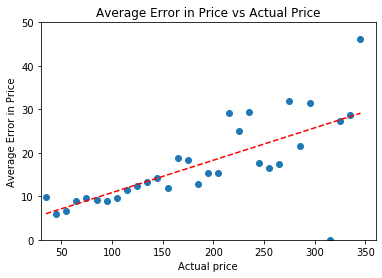

In [238]:
output_list = output.tolist()
label_list = label.tolist()

for i in range(0, len(output_list)):
    output_list[i] = (output_list[i]*mean_std["std"]["price"])+mean_std["mean"]["price"]
    label_list[i] = (label_list[i]*mean_std["std"]["price"])+mean_std["mean"]["price"]

#print(label_list)
#print(output_list)
#print(error)
label_list2 = []
output_list2 = []
    
print(type(real_price))
print(type(train_error))

plt.axis([30, 360, 0, 50])
axes = plt.scatter(x_axis, ave_error_to_plot)
#plt.plot(output_list, label="Predicted Price")

plt.xlabel("Actual price")
plt.ylabel("Average Error in Price")
plt.title("Average Error in Price vs Actual Price")
#plt.legend(loc='best')
#axes.set_ylim([0,100])


z = np.polyfit(x_axis, ave_error_to_plot, 1)
p = np.poly1d(z)
plt.plot(x_axis, p(x_axis),"r--")
    
plt.savefig("../live_demo/Actual_Price_vs_Error_in_Price.png", dpi=300)

In [34]:
a = [2, 4, 5]
type(a)

list